In [1]:
## Define ftns for use in QTL mapping
from matplotlib import pyplot as plt
import numpy as np, pandas as pd, scipy.stats as ss, seaborn as sns

In [2]:
## Set the seed
np.random.seed(71191)

## Write ftn for median filtering
def median_filter(Y,Kernal,padtype=None,recursive=False):
    window = int((Kernal-1)/2)
    Y = np.array(Y)
    assert len(Y[~np.isnan(Y)]) == len(Y)
    if padtype is None:
        rb = np.ones(window)*Y[0]
        re = np.ones(window)*Y[-1]
    elif padtype is 'Zero':
        rb = np.zeros(window)
        re = np.zeros(window)
    elif padtype is 'Ref':
        rb = list(Y[0] - Y[::-1] + Y[0])[-(window+1):-1]
        re = list(Y[-1] - Y[::-1] + Y[-1])[1:(window+1)]
    else:
        rb = np.zeros(window)
        re = np.ones(window)*Y[-1]
    pry = np.concatenate([rb,Y,re])
    if recursive:
        for i in np.arange(window,len(pry)-window):
            pry[i] = np.median(pry[i-window:i+window+1])
        my = pry[window:-window]
    else:
        my = np.array([np.median(pry[i-window:i+window+1]) for i in np.arange(window,len(pry)-window)])
    return my

In [3]:
## Set geno path
geno_path = '../../GENOTYPE/Bt22xFtc555-1_loci.csv.gz'
geno_all_path = '../../GENOTYPE/Bt22xFtc555-1_all_loci.csv.gz'

In [4]:
## Bring in filtered (and filtered segregants)
## genotype data. Also reset to the old index
geno = pd.read_csv(geno_path,index_col=0)
geno.index = geno.Oldindex
geno.head()

,Chrom,Pos,Alleles,Type,PMY2936,PMY2934,PMY2932,PMY2931,PMY2929,PMY2927,...,PMY2926,PMY2807,PMY2808,PMY2810,PMY2902,Oldindex,Newpos,Newchrom,Oldchrom,Maf
Oldindex,,,,,,,,,,,,,,,,,,,,,
5,1,25980,C.T,snp,0,0,1,0,0,1,...,0,1,0,1,0,5,25980,1.0,1.0,0.491857
7,1,26119,ATT.GTT,snp,0,0,1,0,0,1,...,0,1,0,1,0,7,26119,1.0,1.0,0.491857
12,1,26587,ACCTT.TCCAT.TCCTT.GCCTT,complex,0,0,1,0,0,1,...,0,1,0,1,0,12,26587,1.0,1.0,0.491857
15,1,27290,TCCC.CCCC,snp,0,0,1,0,0,1,...,0,1,0,1,0,15,27290,1.0,1.0,0.491857
17,1,28274,GCGCT.ACGCT,snp,0,0,1,0,0,1,...,0,1,0,1,0,17,28274,1.0,1.0,0.491857


In [5]:
## What is the shape of our data
geno.shape

(46760, 316)

In [6]:
## Gather a list of the chromosomes
## There should be 14
chrlist = geno.Chrom.unique()
chrlist

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [7]:
## CHeck for duplicate positions
## There should be zero
## if there are some you need to go back
duplicates = []
for c in chrlist:
    
    temp = geno[(geno.Chrom==c)]
    
    p,k = np.unique(temp.Pos.values,return_counts=True)
    
    duplicate_pos = p[(k == 2)]
        
    for p in duplicate_pos:

        duplicates.append((p,c))
assert len(duplicates) == 0

In [8]:
## Bring in the genotype data for all the segregants
genoall = pd.read_csv(geno_all_path,index_col=0)
genoall.head()

,Seqid,Pos,Qual,Callrate,Nallele,Alleles,Maxlen,Minlen,Depth,Type,...,PMY2661,PMY2793,PMY2926,PMY2803,PMY2807,PMY2808,PMY2810,Chrom,H99_allele,OA
5,CP003820.1,25980,162643.0,0.992188,1,C.T,1,1,11167,snp,...,1,1,0,1,1,0,1,1,0.505208,381
7,CP003820.1,26119,136525.0,0.986979,1,ATT.GTT,3,3,9049,snp,...,1,1,0,1,1,0,1,1,0.481771,379
12,CP003820.1,26587,331282.0,0.984375,3,ACCTT.TCCAT.TCCTT.GCCTT,5,5,10786,complex,...,1,1,0,1,1,0,1,1,0.984375,377
15,CP003820.1,27290,187697.0,0.992188,1,TCCC.CCCC,4,4,13248,snp,...,1,1,0,1,1,0,1,1,0.481771,381
17,CP003820.1,28274,217593.0,0.997396,1,GCGCT.ACGCT,5,5,14944,snp,...,1,1,0,1,1,0,1,1,0.484375,383


In [9]:
## gather segregants
segs = [s for s in geno.columns if s[:3]=='PMY']
segs_all = [s for s in genoall.columns if s[:3] == 'PMY']
len(segs),len(segs_all)

(307, 384)

In [10]:
## Bring in clones
clones = pd.read_csv('../../NOTES/Clone_strains.csv')
clones.head()

,s1,s2,s3,s4
0,PMY2556,PMY2557,PMY2566,PMY2574
1,PMY2559,PMY2577,NaN,NaN
2,PMY2560,PMY2562,PMY2595,NaN
3,PMY2564,PMY2579,NaN,NaN
4,PMY2568,PMY2597,NaN,NaN


In [11]:
## make list of clones
clone_segs = list(np.unique(np.concatenate([clones[s].dropna().values 
                             for s in clones.columns])))

In [12]:
## Gather segregants to examine
lookat = [s for s in segs_all if s not in clone_segs+segs+['PMY2923','PMY2763']]
len(lookat)

32

In [13]:
## Gather the postions and index to keep
keep_index = []
for c in chrlist:
    
    temp1 = geno[(geno.Chrom==c)]
    
    temp2 = genoall[(genoall.Chrom==c)]
    
    posix = temp2[(temp2.Pos.isin(temp1.Pos))].index
    
    keep_index.append(posix)
    
keep_index = np.concatenate(keep_index)
len(keep_index)

46760

In [14]:
## check the subtraction of pos isiont and chromosome by index
assert np.sum(genoall.loc[geno.Oldindex].Pos.values - geno.loc[geno.Oldindex].Pos.values) == 0
assert np.sum(genoall.loc[geno.Oldindex].Chrom.values - geno.loc[geno.Oldindex].Chrom.values) == 0

In [15]:
## Take the genotype data of segregants left to examine
geno_lookat = genoall.loc[geno.Oldindex,:]
geno_lookat.shape

(46760, 397)

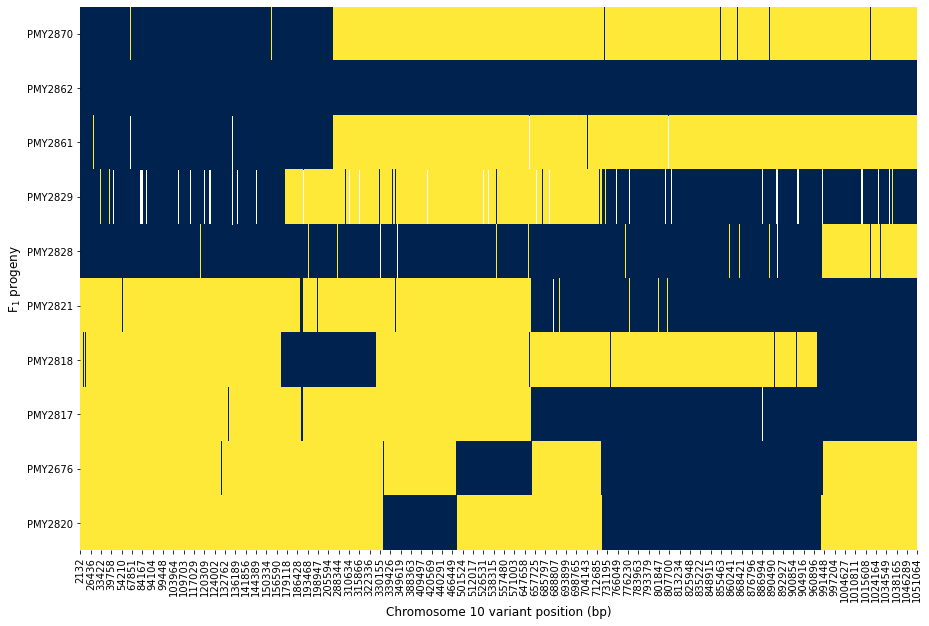

In [23]:
## For a few segregants, plot the genotypes of a chromosome
## for chromosome 2
ns = 10
chrom = 10
parentdf = geno_lookat[(geno_lookat.Chrom==10) ][['Pos']+lookat[:ns]]
parentdf.index = parentdf.Pos
parentdf.drop('Pos',axis=1,inplace=True)
fig,ax = plt.subplots(1,1,figsize=(15,10))

sns.heatmap(parentdf.replace(-1,np.nan).T,
            cmap='cividis',cbar=False,vmax=1,vmin=0);
plt.yticks(rotation=0)
plt.xlabel('Chromosome %s variant position (bp)'%chrom,fontsize=12)
plt.ylabel('F$_{1}$ progeny',fontsize=12);
plt.savefig('../../FIGURES/Corrupted_chromosome_%s.png'%(chrom),
            dpi=100,bbox_inches='tight');

In [24]:
geno_lookat['Newchrom'] = geno.loc[geno_lookat.index,'Newchrom']
geno_lookat['Newpos'] = geno.loc[geno_lookat.index,'Newpos']
geno_lookat['Oldindex'] = geno_lookat.index.values
geno_lookat.sort_values(['Newchrom','Newpos'],inplace=True)
geno_lookat.reset_index(inplace=True,drop=True)
geno_lookat.head()

,Seqid,Pos,Qual,Callrate,Nallele,Alleles,Maxlen,Minlen,Depth,Type,...,PMY2803,PMY2807,PMY2808,PMY2810,Chrom,H99_allele,OA,Newchrom,Newpos,Oldindex
0,CP003820.1,25980,162643.0,0.992188,1,C.T,1,1,11167,snp,...,1,1,0,1,1,0.505208,381,1.0,25980,5
1,CP003820.1,26119,136525.0,0.986979,1,ATT.GTT,3,3,9049,snp,...,1,1,0,1,1,0.481771,379,1.0,26119,7
2,CP003820.1,26587,331282.0,0.984375,3,ACCTT.TCCAT.TCCTT.GCCTT,5,5,10786,complex,...,1,1,0,1,1,0.984375,377,1.0,26587,12
3,CP003820.1,27290,187697.0,0.992188,1,TCCC.CCCC,4,4,13248,snp,...,1,1,0,1,1,0.481771,381,1.0,27290,15
4,CP003820.1,28274,217593.0,0.997396,1,GCGCT.ACGCT,5,5,14944,snp,...,1,1,0,1,1,0.484375,383,1.0,28274,17


In [25]:
segxm = pd.DataFrame([np.sum(geno_lookat[seg] == -1) for seg in lookat],
            columns=['NM'], index = lookat).sort_values('NM')
segxm.tail()

,NM
PMY2585,12692
PMY2829,15117
PMY2587,16947
PMY2600,27411
PMY2741,44658


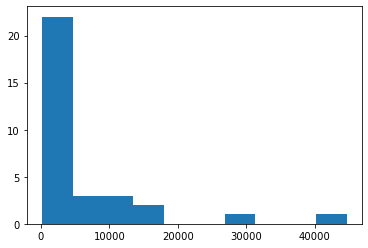

In [26]:
plt.hist(segxm.NM.values);

In [27]:
chrlist = geno.Newchrom.unique()

kernals = np.arange(3,21,2)
kernal_kb = []
for ks in kernals:
    ch_kb = []
    for c in chrlist[-1:]:
        
        temp = geno[(geno.Newchrom==c)].Newpos.values
        
        for i in range(len(temp)):
            
            l = int(i-((ks-1)/2))
            r = int(i+((ks-1)/2))
            k = temp[(l if l > 0 else 0): (r if r < len(temp) else len(temp))]
            
            kb = np.max(k) - np.min(k)
            
            ch_kb.append(np.log10(np.array(kb)+1))
            
    kernal_kb.append(ch_kb) 

In [28]:
len(kernals)

9

In [29]:
len(kernal_kb)

9

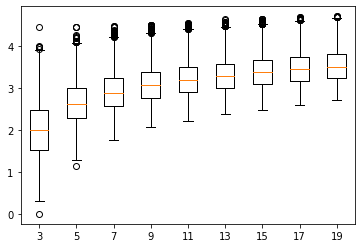

In [30]:
plt.boxplot(kernal_kb);
plt.xticks(np.arange(len(kernals))+1,kernals);

In [31]:
np.median(kernal_kb[1])**10

16104.40037230467

In [34]:
segxm.tail()

,NM
PMY2585,12692
PMY2829,15117
PMY2587,16947
PMY2600,27411
PMY2741,44658


10.0


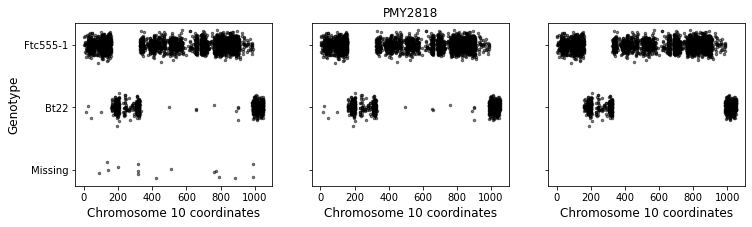

In [40]:
chrlist = geno_lookat.Newchrom.unique().tolist()

s = segxm.NM.index[0]
#s = 'PMY2829'
s = 'PMY2818'
c = chrlist[9]
print(c)

df = geno_lookat[(geno_lookat.Newchrom==c)
                   ][[s]].copy()

dfp= df.copy()

df[s].replace(dict(zip([-1],[np.nan])),inplace=True)
assert df[(df[s] == -1)].shape[0] == 0

r = 1
KS = 5

dfp['N'] = np.round(np.nansum(df[::r].fillna(method='ffill') + df[::r].fillna(method='bfill'),axis=1)/2)[::r]
dfp['M'] = median_filter(dfp['N'][::r],Kernal=KS,padtype='Ref',recursive=True)[::r]
dfp['Newpos'] = geno_lookat[(geno_lookat.Newchrom==c)
                   ]['Newpos']

jitter = np.random.normal(0,0.08,dfp.shape[0])

## Plot the chormosomes genotypes
fig,ax = plt.subplots(1,3,figsize=(12,3),sharex=True,sharey=True)

for i,k in enumerate([s,'N','M']):
    plt.sca(ax[i])
    plt.plot(dfp.Newpos,dfp[k].values+jitter,
             'k.',alpha=0.5,ms=5)
    
    plt.ylabel('Genotype'if i == 0 else None,fontsize=12)
    plt.xlabel('Chromosome %s coordinates'%int(c),fontsize=12);
    plt.title(s if i == 1 else None,fontsize=12)
    
xp,xl = plt.xticks()
plt.xticks(xp[1:-1],[int(x) for x in xp[1:-1]/1000])
plt.yticks([-1,0,1],['Missing','Bt22','Ftc555-1'],
        fontsize=12);
plt.savefig('../../FIGURES/Genotype_rescue_example_%s_%s.png'%(
                str(c),s),
            dpi=200,bbox_inches='tight')

In [43]:
r = 1 
KS = 11

for s in segxm.NM.index[:-2]:
    new_col = s+'_cor'
  
    geno[new_col] = -1
    
    for c in chrlist:
        
        df = geno_lookat[(geno_lookat.Newchrom==c)
                   ][[s]].copy()

        dfp = df.copy()

        df[s].replace(dict(zip([-1],[np.nan])),inplace=True)
        assert df[(df[s] == -1)].shape[0] == 0

        dfp['N'] = np.round(np.nansum(df[::r].fillna(method='ffill') + df[::r].fillna(method='bfill'),axis=1)/2)[::r]
        dfp['M'] = median_filter(dfp['N'][::r],Kernal=KS,padtype='Ref',recursive=True)[::r]
        
        dfp.index = geno_lookat[(geno_lookat.Newchrom==c)
                                       ]['Oldindex']
        
        geno.loc[dfp.index,new_col] = dfp['M']

In [44]:
new_segs = [s+'_cor' for s in segxm.NM.index[:-2]]
len(new_segs)

30

In [45]:
assert geno[new_segs].min().min() > -1

In [46]:
chrom

10

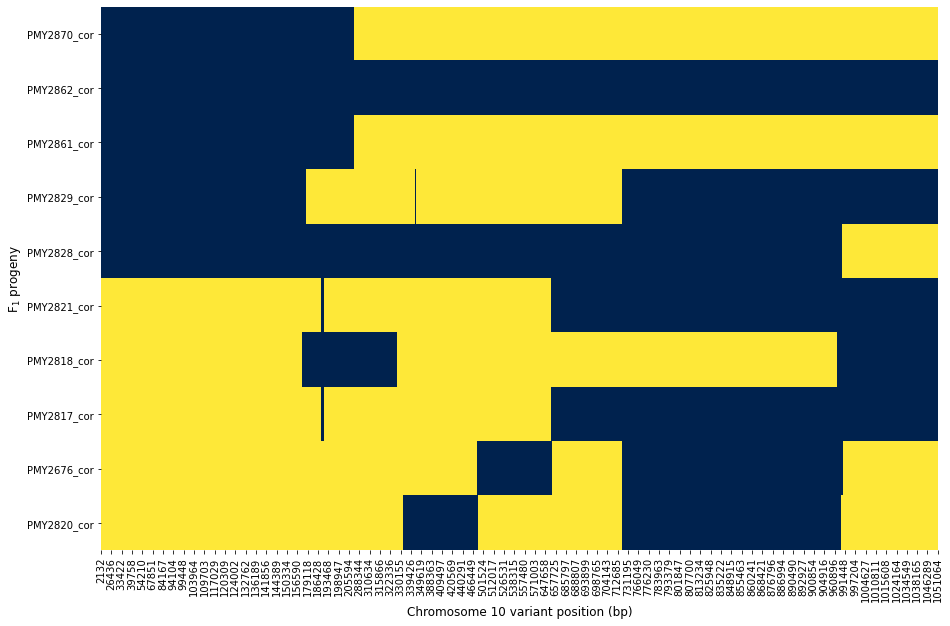

In [47]:
## For a few segregants, plot the genotypes of a chromosome
## for chromosome 2
ns = 10
parentdf = geno[(geno.Chrom==chrom) ][['Pos']+[
    s+'_cor' for s in lookat[:ns]]]
parentdf.index = parentdf.Pos
parentdf.drop('Pos',axis=1,inplace=True)
fig,ax = plt.subplots(1,1,figsize=(15,10))

sns.heatmap(parentdf.replace(-1,np.nan).T,
            cmap='cividis',cbar=False,vmax=1,vmin=0);
plt.yticks(rotation=0)
plt.xlabel('Chromosome %s variant position (bp)'%chrom,fontsize=12)
plt.ylabel('F$_{1}$ progeny',fontsize=12);
plt.savefig('../../FIGURES/Corrupted_chromosome_%s_cor.png'%(chrom),
            dpi=100,bbox_inches='tight');

In [30]:
mapping_pop = list(segs) + list(new_segs)
len(mapping_pop)

337

In [31]:
geno[segs].drop_duplicates().shape

(4797, 307)

In [32]:
uloci = geno[mapping_pop].drop_duplicates()
uloci.shape

(5119, 337)

In [33]:
parent_pmy = ['PMY2649', 'PMY2650']

In [34]:
## Calculate genotypic corrilations between strains
clone_ranks = []
ht = 0.5

## Take just progeny
map_prog = [p for p in mapping_pop if p not in parent_pmy]

for i,s in enumerate(map_prog):
    for j,k in enumerate(map_prog):
        if j>i:
            s1 = uloci[s].values
            s2 = uloci[k].values
            
            p = ss.spearmanr(s1,s2)[0]
            if p > ht:
                clone_ranks.append((p,s,k))
            else:
                pass
        else:
            pass

## Make paired strain corrilations into a dataframe
clonerank = pd.DataFrame(clone_ranks,
                         columns = ['p','s1','s2']
                        ).sort_values('p')
clonerank.head()

,p,s1,s2
7,0.960123,PMY2594,PMY2587_cor
14,0.971042,PMY2584_cor,PMY2585_cor
3,0.980384,PMY2840,PMY2817_cor
0,0.980513,PMY2599,PMY2589_cor
1,0.982555,PMY2844,PMY2823_cor


In [35]:
## How many ranks are above 50% and what is the corrilations
clonerank[(clonerank.p>0.50)].shape[0],clonerank[(clonerank.p>0.50)].p.min()

(17, 0.9601234218811827)

In [36]:
## Gather the unique strains that are clones
unique_clones = list(sorted(np.unique(clonerank.s1.tolist() + clonerank.s2.tolist())))
len(unique_clones)

28

In [37]:
## Sort the clones by strain
clones_sorted = pd.DataFrame([[j.p] + list(sorted(j[['s1','s2']])) 
                              for i,j in clonerank.iterrows()],
                             columns=clonerank.columns).sort_values('s1')
clones_sorted.head()

,p,s1,s2
12,0.992914,PMY2559,PMY2602_cor
8,0.989446,PMY2561,PMY2580_cor
6,0.984771,PMY2567,PMY2586_cor
1,0.971042,PMY2584_cor,PMY2585_cor
0,0.960123,PMY2587_cor,PMY2594


In [38]:
## Group the clones
clones_grouped = []

for s in unique_clones:
    sub = clones_sorted[(clones_sorted.s1==s)].s2.tolist() + [s]
    group = np.unique(np.concatenate(
                clones_sorted[
                (clones_sorted.s1.isin(sub)) | 
                (clones_sorted.s2.isin(sub))
                ][['s1','s2']].values))
    
    if group[-1].split("_")[-1] != 'cor':
        group = group[::-1]

    clones_grouped.append(group)
    
## make into dataframe 
cg = pd.DataFrame(clones_grouped,
                  columns=['s1','s2','s3']
                 ).sort_values('s1')

## Drop the duplicate clone groups
clone_groups = cg.drop_duplicates().reset_index(drop=True)

## save
clone_groups.to_csv('../../NOTES/Clone_strains_cor.csv',
                    index=False)

## View head
clone_groups

,s1,s2,s3
0,PMY2559,PMY2602_cor,None
1,PMY2561,PMY2580_cor,None
2,PMY2567,PMY2586_cor,None
3,PMY2584_cor,PMY2585_cor,None
4,PMY2594,PMY2587_cor,None
5,PMY2599,PMY2589_cor,None
6,PMY2617,PMY2620_cor,None
7,PMY2653,PMY2604_cor,None
8,PMY2673,PMY2719_cor,None
9,PMY2702,PMY2690_cor,None


In [39]:
newest_clones = [c.dropna().tolist() for i,c in clone_groups.iterrows()]

In [40]:
old_clones = [c.dropna().tolist() for i,c in clones.iterrows()]

In [41]:
old_clones[:5]

[['PMY2556', 'PMY2557', 'PMY2566', 'PMY2574'],
 ['PMY2559', 'PMY2577'],
 ['PMY2560', 'PMY2562', 'PMY2595'],
 ['PMY2564', 'PMY2579'],
 ['PMY2568', 'PMY2597']]

In [42]:
old_clone_ix = []
new_clone_ix = []
clone_fin_ix = []
for i,c in enumerate(newest_clones):
    for j,k in enumerate(old_clones):
        
        if np.max([(seg in k) for seg in c]):
            cix = j
        else:
            cix = -1
            
        
        if cix > -1:
            clone_fin_ix.append((i,cix))
            new_clone_ix.append(i)
            old_clone_ix.append(cix)
            
clone_fin_ix

[(0, 1), (6, 11), (8, 20)]

In [43]:
fin_clones = []

for j,k in enumerate(old_clones):
    
    if j in old_clone_ix:
        
        ncix = new_clone_ix[(old_clone_ix.index(j))]
        
        print(j,ncix)
        new_clones = np.unique(k+newest_clones[ncix])
    else:
        new_clones = k
    
    fin_clones.append(new_clones)
    
for i,c in enumerate(newest_clones):
    
    if i in new_clone_ix:
        pass
    else:
        fin_clones.append(c)

1 0
11 6
20 8


In [44]:
len(fin_clones),len(old_clones)

(47, 37)

In [45]:
clones.columns

Index(['s1', 's2', 's3', 's4'], dtype='object')

In [46]:
final_clones = pd.DataFrame(fin_clones,
                            columns=clones.columns).sort_values('s1')

In [47]:
final_clones.tail()

,s1,s2,s3,s4
45,PMY2844,PMY2823_cor,None,None
34,PMY2866,PMY2872,None,None
46,PMY2871,PMY2870_cor,PMY2861_cor,None
35,PMY2899,PMY2909,None,None
36,PMY2900,PMY2902,None,None


In [48]:
final_clones.to_csv('../../NOTES/Clone_strains_all.csv',index=False)

In [49]:
for seg in final_clones['s1']:
    
    if (seg not in segs) and (seg not in new_segs):
        
        next_clone = final_clones[(final_clones['s1']==seg)]['s2'].min()
        if next_clone  not in segs:
            print('Error')
        else:
            print('%s chosen over %s'%(next_clone,seg))

PMY2902 chosen over PMY2900


In [50]:
final_clones.loc[36,'s1'] = 'PMY2902'
final_clones.loc[36,'s2'] = 'PMY2900'

In [51]:
final_clones.tail()

,s1,s2,s3,s4
45,PMY2844,PMY2823_cor,None,None
34,PMY2866,PMY2872,None,None
46,PMY2871,PMY2870_cor,PMY2861_cor,None
35,PMY2899,PMY2909,None,None
36,PMY2902,PMY2900,None,None


In [52]:
len(mapping_pop)

337

In [53]:
clones_to_drop = np.concatenate([c.dropna().tolist() 
                  for i,c in 
                  final_clones[['s2','s3','s4']].iterrows()])
len(clones_to_drop)

58

In [54]:
clone_remove = []
clone_not = []
clone_kept = []

for s in mapping_pop:
    
    if s in final_clones['s1'].tolist():
        clone_kept.append(s)
        
    elif s in clones_to_drop:
        clone_remove.append(s)
        
    else:
        clone_not.append(s)

In [55]:
len(clone_not)

275

In [56]:
len(clone_kept),final_clones.shape[0]

(47, 47)

In [57]:
len(clone_remove)

15

In [58]:
final_mapping_pop = sorted(clone_not + clone_kept)
len(final_mapping_pop)

322

In [59]:
new_strains = [s for s in final_mapping_pop if s.split('_')[-1]=='cor']

assert len(new_strains) == len(final_mapping_pop) - len(segs)

len(new_strains)

15

In [60]:
info_cols = [c for c in geno.columns if c not in 
             final_mapping_pop and c[:3]!='PMY']
info_cols

['Chrom',
 'Pos',
 'Alleles',
 'Type',
 'Oldindex',
 'Newpos',
 'Newchrom',
 'Oldchrom',
 'Maf']

In [61]:
savepath = geno_path.split('.csv')[0] + '_cor.csv.gz'

In [62]:
geno_save = geno[info_cols+final_mapping_pop].copy()

In [63]:
geno_save.columns = [c.split('_co')[0] for c in geno_save.columns]

In [64]:
geno_save.drop('Oldindex',axis=1,inplace=True)

In [65]:
geno_save.to_csv(savepath,index=True)